In [98]:
import autograd.numpy as np  
from autograd import grad, elementwise_grad
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [99]:
#Defining some activation functions and their derivative
def ReLU(z):
    return np.where(z > 0, z, 0)

def ReLU_der(z):
    return np.where(z > 0, 1, 0)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_der(z):
    return sigmoid(z) * (1 - sigmoid(z))

def mse(predict, target):
    return np.mean((predict - target) ** 2)

def mse_der(predict, target):
    return 2 * (predict - target) / np.prod(predict.shape)

def softmax(z):
    """Compute softmax values for each set of scores in the rows of the matrix z.
    Used with batched input data."""
    e_z = np.exp(z - np.max(z, axis=1)[:, np.newaxis]) #substract max per row, avoids instability
    return e_z / np.sum(e_z, axis=1)[:, np.newaxis]

def softmax_vec(z):
    """Compute softmax values for each set of scores in the vector z.
    Use this function when you use the activation function on one vector at a time"""
    e_z = np.exp(z - np.max(z))
    return e_z / np.sum(e_z)

def softmax_der(z):
    return np.ones_like(z) 
#Purely placeholder, combined derivative 
#Cross entropy + softmax simplifies to predict-target

def cross_entropy(predict, target):
    return np.mean(-np.sum(target * np.log(predict + 1e-10), axis=1))

def cross_entropy_der(predict, target):
    return (predict - target) / predict.shape[0]


In [100]:
#Initializing creation of n layers for batched input shapes
def create_layers_batch(network_input_size, layer_output_sizes):
    layers = []

    i_size = network_input_size
    for layer_output_size in layer_output_sizes:
        std = np.sqrt(2.0 / i_size)
        W = np.random.randn(layer_output_size, i_size) * std
        W = W.T
        b = np.random.randn(layer_output_size)
        layers.append((W, b))

        i_size = layer_output_size
    return layers

#Applying weights, bias and activation function and passing forward
def feed_forward_saver_batch(input, layers, activation_funcs):
    layer_inputs = []
    zs = []
    a = input
    for (W, b), activation_func in zip(layers, activation_funcs):
        layer_inputs.append(a)
        z = a @ W + b
        a = activation_func(z)

        zs.append(z)

    return layer_inputs, zs, a

#Same, but when saving layer_inputs and zs is not needed
def feed_forward(input, layers, activation_funcs):
    a = input
    for (W, b), activation_func in zip(layers, activation_funcs):
        z = a @ W + b
        a = activation_func(z)
    return a

#Verify gradients
def cost(input, layers, activation_funcs, target):
    predict = feed_forward_saver_batch(input, layers, activation_funcs)[2]
    return mse(predict, target)

#Computing gradients
def backpropagation_batch(
    input, layers, activation_funcs, target, activation_ders, cost_der=mse_der
):
    layer_inputs, zs, predict = feed_forward_saver_batch(input, layers, activation_funcs)

    layer_grads = [() for layer in layers]

    # We loop over the layers, from the last to the first
    for i in reversed(range(len(layers))):
        layer_input, z, activation_der = layer_inputs[i], zs[i], activation_ders[i]

        if i == len(layers) - 1:
            # For last layer we use cost derivative as dC_da(L) can be computed directly
            dC_da = cost_der(predict, target)
        else:
            # For other layers we build on previous z derivative, as dC_da(i) = dC_dz(i+1) * dz(i+1)_da(i)
            (W, b) = layers[i + 1]
            dC_da = dC_dz @ W.T

        dC_dz = dC_da * activation_der(z)
        dC_dW = layer_input.T @ dC_dz  #W gradients for batches
        dC_db = np.sum(dC_dz, axis=0)   #sum bias gradients, batch dim

        layer_grads[i] = (dC_dW, dC_db)

    return layer_grads

In [101]:
#Gradient verification with autograd

network_input_size = 4
batch_size = 400
layer_output_sizes = [3, 4]
activation_funcs = [sigmoid, ReLU]
activation_ders = [sigmoid_der, ReLU_der]
la = create_layers_batch(network_input_size, layer_output_sizes)

x = np.random.randn(batch_size, network_input_size)
input = x
target = np.random.rand(4)

computed = backpropagation_batch(input, la, activation_funcs, target, activation_ders)
print(computed[-1][0][0])

cost_grad = grad(cost, 1)
autoG = cost_grad(input, la, activation_funcs, target)
print(autoG[-1][0][0])

diff = 0
for i in range(len(computed)):
    diff += abs(computed[-1][0][i][0])-abs(autoG[-1][0][0][0])
if diff <= 10**-6:
    print("Same gradients")


[ 0.         -0.00152567  0.07777453  0.06810808]
[ 0.         -0.00152567  0.07777453  0.06810808]
Same gradients


In [102]:
# MY OWN DIGIT
import numpy as np
from PIL import Image

# ───────────────────────────────────────────────
# Option A – Most recommended today (clean & simple)
# ───────────────────────────────────────────────

    # Load & force grayscale + 28×28
img = Image.open("DIGIT.0.BLACK.28.28.png").convert('L')           # 'L' = grayscale
img = img.resize((28, 28), Image.Resampling.NEAREST)  # or LANCZOS for smoother

arr = np.array(img)                           # shape (28,28), values 0-255
for i in range(28):
    for j in range(28):
        arr[i,j] = round(arr[i,j])            # classic Python round()
        arr[i,j] = 255-arr[i,j]

    # Decide inversion based on your drawing style:
    # Case 1: white paper + dark ink  → NO inversion

#print(arr)
arr = arr / 255.0
for row in arr:
    print(' '.join(f"{x:2}" for x in row))
    # Case 2: black background + light digit → invert
    # arr = (255 - arr) / 255.0

    # Optional: slight threshold / contrast boost (helps a lot!)
    # arr = np.maximum(arr - 0.05, 0) ** 1.3     # remove very light noise + increase contrast

# Your 28×28 array (can be int or float)
arr_2d = np.array(arr)          # shape (28, 28)

# Flatten it
vector = arr_2d.flatten()       # or arr_2d.ravel()

print(vector.shape)             # → (784,)

"""

# ───────────────────────────────────────────────
# Option B – Very explicit version (good for learning)
# ───────────────────────────────────────────────
arr = np.array(Image.open("my_digit.png").convert('L'))
arr = arr.astype(np.float32)

# Invert if your drawing has dark ink on light background (most natural)
# Comment out the next line if your canvas is already black background
arr = 255 - arr

# Normalize to 0–1 (this is what almost all good MNIST models expect)
arr = arr / 255.0

# Optional: simple contrast enhancement
arr = np.clip((arr - 0.1) * 1.4, 0, 1)           # kills faint noise, boosts digit
for i in range(28):
    for j in range(28):
        arr[i,j] = round(arr[i,j])            # classic Python round()
"""

0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196
0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 0.00784313725490196 

'\n\n# ───────────────────────────────────────────────\n# Option B – Very explicit version (good for learning)\n# ───────────────────────────────────────────────\narr = np.array(Image.open("my_digit.png").convert(\'L\'))\narr = arr.astype(np.float32)\n\n# Invert if your drawing has dark ink on light background (most natural)\n# Comment out the next line if your canvas is already black background\narr = 255 - arr\n\n# Normalize to 0–1 (this is what almost all good MNIST models expect)\narr = arr / 255.0\n\n# Optional: simple contrast enhancement\narr = np.clip((arr - 0.1) * 1.4, 0, 1)           # kills faint noise, boosts digit\nfor i in range(28):\n    for j in range(28):\n        arr[i,j] = round(arr[i,j])            # classic Python round()\n'

In [103]:
#Applying FFNN base above to classification problem, MNIST:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#Fetch the MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')

#Extract data
X = mnist.data


y_labels = mnist.target.astype(int)
X = X / 255.0

print(y_labels[-1])
#One-hot encode labels
y = np.eye(10)[y_labels] #Convert to integers
print(y[0])

#Split into train and test
#y_train_labels and y_test_labels for scikit-learn, expects integer labels
X_train, X_test, y_train, y_test, y_train_labels, y_test_labels = train_test_split(
    X, y, y_labels, test_size=0.1, random_state=42
)


import numpy as np

# Assuming X_train is your (N, 784) array from MNIST
# Let's take the very first image as example
digit = X[0]           # shape (784,)
digit_2d = digit.reshape(28, 28)   # now (28, 28)

# Print nicely
for row in digit_2d:
    print(' '.join(f"{(x)}" for x in row))   # ×255 and int to get 0-255 range


print(X_train.shape)
print(y_train.shape)
print(28*28)

6
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.011764705882352941 0.07058823529411765 0.07058823529411765 0.07058823529411765 0.49411764705882355 0.5333333333333333 0.6862745098039216 0.10196078431372549 0.6509803921568628 1.0 0.9686274509803922 0.4980392156862745 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.11764705882352941 0.1411764705882353 0.3686274509803922 0.6039215686274509 0.66666666666

In [104]:
def accuracy(predictions, targets):
    one_hot_predictions = np.zeros(predictions.shape)
    for i, prediction in enumerate(predictions):
        one_hot_predictions[i, np.argmax(prediction)] = 1
    return accuracy_score(one_hot_predictions, targets)

In [105]:
import numpy as np

# ============================
# OPTIMIZER FACTORY + STATE
# ============================

def create_optimizer(optimizer_name="adam", lr=0.001):
    if optimizer_name == "sgd":
        return {"name": "sgd", "lr": lr}
    
    elif optimizer_name == "adam":
        return {
            "name": "adam",
            "lr": lr,
            "beta1": 0.9,
            "beta2": 0.999,
            "epsilon": 1e-8,
            "t": 0,
            "m": [],   # will hold (m_W, m_b) for each layer
            "v": []    # will hold (v_W, v_b) for each layer
        }
    
    elif optimizer_name == "rmsprop":
        return {
            "name": "rmsprop",
            "lr": lr,
            "beta": 0.99,
            "epsilon": 1e-8,
            "v": []
        }
    else:
        raise ValueError("Unknown optimizer")

# ============================
# MAIN UPDATE FUNCTION
# ============================

def update_parameters(layers, grads, optimizer_config, t=None):
    """
    One function to rule them all.
    Pass in your layers, gradients, and optimizer config → returns updated layers
    """
    name = optimizer_config["name"]
    
    if name == "sgd":
        lr = optimizer_config["lr"]
        updated_layers = []
        for (W, b), (dW, db) in zip(layers, grads):
            W = W - lr * dW
            b = b - lr * db
            updated_layers.append((W, b))
        return updated_layers

    elif name == "adam":
        # Initialize m and v on first call
        if len(optimizer_config["m"]) == 0:
            optimizer_config["m"] = [(np.zeros_like(W), np.zeros_like(b)) for W, b in layers]
            optimizer_config["v"] = [(np.zeros_like(W), np.zeros_like(b)) for W, b in layers]
        
        beta1 = optimizer_config["beta1"]
        beta2 = optimizer_config["beta2"]
        lr = optimizer_config["lr"]
        eps = optimizer_config["epsilon"]
        t = optimizer_config["t"] + 1
        optimizer_config["t"] = t  # update timestep

        updated_layers = []
        for i, ((W, b), (dW, db)) in enumerate(zip(layers, grads)):
            m_W, m_b = optimizer_config["m"][i]
            v_W, v_b = optimizer_config["v"][i]

            # Adam update (per parameter)
            m_W = beta1 * m_W + (1 - beta1) * dW
            m_b = beta1 * m_b + (1 - beta1) * db
            v_W = beta2 * v_W + (1 - beta2) * (dW ** 2)
            v_b = beta2 * v_b + (1 - beta2) * (db ** 2)

            m_hat_W = m_W / (1 - beta1 ** t)
            m_hat_b = m_b / (1 - beta1 ** t)
            v_hat_W = v_W / (1 - beta2 ** t)
            v_hat_b = v_b / (1 - beta2 ** t)

            W = W - lr * m_hat_W / (np.sqrt(v_hat_W) + eps)
            b = b - lr * m_hat_b / (np.sqrt(v_hat_b) + eps)

            # Save back
            optimizer_config["m"][i] = (m_W, m_b)
            optimizer_config["v"][i] = (v_W, v_b)
            updated_layers.append((W, b))

        return updated_layers

    # You can easily add RMSprop, AdamW, etc. here

In [106]:
def dropout(x, keep_prob=0.8, training=True):
    """
    keep_prob = probability a neuron is KEPT (not dropped)
    0.8 → drop 20 % of neurons (best for hidden layers)
    0.5 → drop 50 % (sometimes used, but 0.8–0.9 is better for ReLU nets)
    """
    if training:
        mask = np.random.rand(*x.shape) < keep_prob     # random mask
        return x * mask / keep_prob                     # ← INVERTED DROPOUT (important!)
    else:
        return x                                        # no dropout at test time
    
def ReLU_with_dropout(z, keep_prob=0.8, training=True):
    a = ReLU(z)
    return dropout(a, keep_prob=keep_prob, training=training)

Epoch 1, Loss: 0.091, Test Accuracy: 0.961, Train Accuracy: 0.972
Epoch 2, Loss: 0.051, Test Accuracy: 0.972, Train Accuracy: 0.984
Epoch 3, Loss: 0.063, Test Accuracy: 0.964, Train Accuracy: 0.979
Epoch 4, Loss: 0.036, Test Accuracy: 0.975, Train Accuracy: 0.988
Epoch 5, Loss: 0.019, Test Accuracy: 0.975, Train Accuracy: 0.994


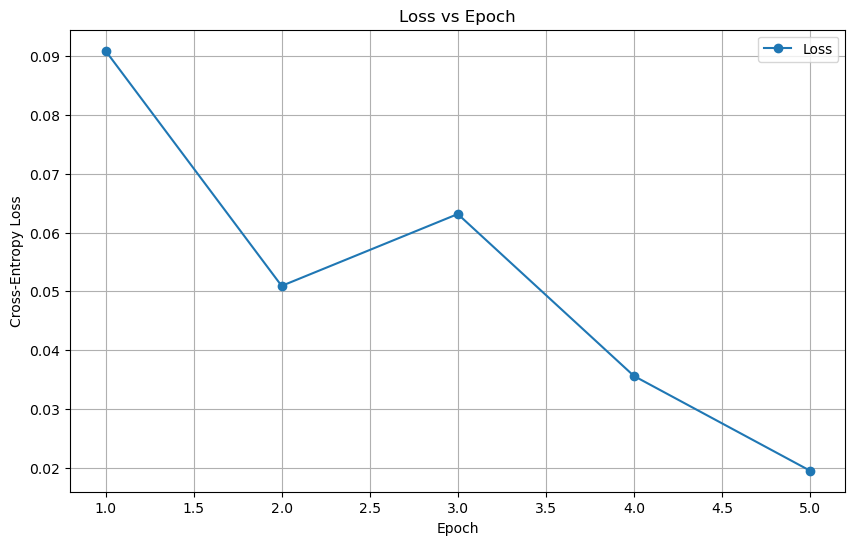

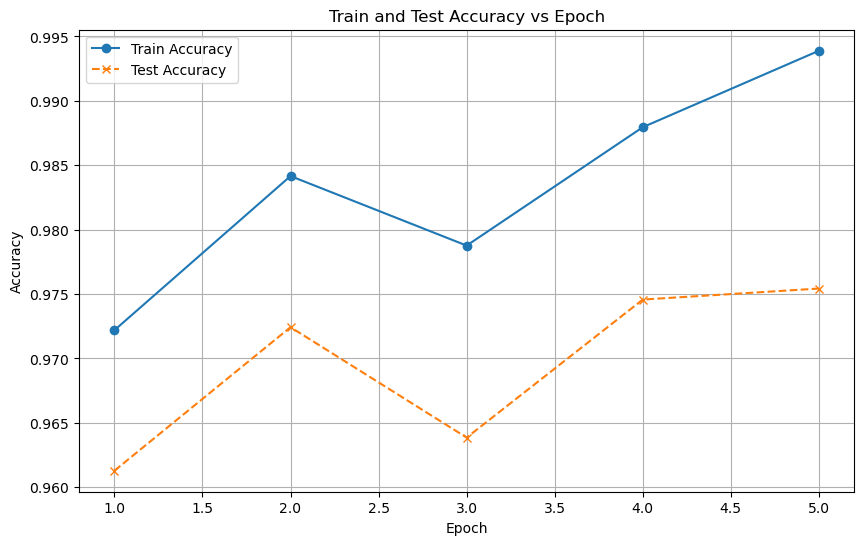

'\n#Scikit-learn Logistic Regression comparison\nmodel = LogisticRegression(solver=\'saga\', multi_class=\'multinomial\', max_iter=10, random_state=42)\nmodel.fit(X_train, y_train_labels)\ny_pred = model.predict(X_test)\nsk_accuracy = accuracy_score(y_test_labels, y_pred)\nprint(f"Scikit-learn Model Accuracy: {sk_accuracy:.4f}")\n'

In [107]:

def train_network(X_train, y_train, layers, activation_funcs, activation_ders, learning_rate, epochs, batch_size=100):
    losses = []
    train_accs = []  
    test_accs = [] 
    #
    optimizer = create_optimizer("adam", lr=0.001)   # or "sgd", lr=0.05
    #
    for epoch in range(epochs):
        # Shuffle digits, avoids learning misleading patterns. Independent data
        perm = np.random.permutation(X_train.shape[0])
        X_shuffled = X_train[perm] 
        y_shuffled = y_train[perm]
        
        # Mini-batch loop
        for start in range(0, X_train.shape[0], batch_size):
            end = start + batch_size
            input_batch = X_shuffled[start:end]
            target_batch = y_shuffled[start:end]
            
            layers_grad = backpropagation_batch(input_batch, layers, activation_funcs, target_batch, activation_ders, cost_der=cross_entropy_der)
            #
            layers = update_parameters(layers, layers_grad, optimizer)
            #
            for (W, b), (W_g, b_g) in zip(layers, layers_grad):
                W -= learning_rate * W_g
                b -= learning_rate * b_g
        
        # Compute loss after epoch
        train_predictions = feed_forward(X_train, layers, activation_funcs)
        test_predictions = feed_forward(X_test, layers, activation_funcs)
        loss = cross_entropy(train_predictions, y_train)
        TESTacc = accuracy(test_predictions, y_test)
        TRAINacc = accuracy(train_predictions, y_train)
        losses.append(loss)
        train_accs.append(TRAINacc)  
        test_accs.append(TESTacc)    
        print(f"Epoch {epoch+1}, Loss: {loss:.3f}, Test Accuracy: {TESTacc:.3f}, Train Accuracy: {TRAINacc:.3f}") 
    
    return layers, losses, train_predictions, train_accs, test_accs  # Updated return

# Setup network skeleton 
network_input_size = 784
layer_output_sizes = [512, 256, 128, 10]  # output 10 classes
#activation_funcs = [ReLU, ReLU, ReLU, softmax]
activation_ders = [ReLU_der, ReLU_der, ReLU_der, softmax_der]

#NEW
# After (dropout on hidden layers only!)
activation_funcs = [
    lambda z: ReLU_with_dropout(z, keep_prob=0.99, training=True),
    lambda z: ReLU_with_dropout(z, keep_prob=0.99, training=True),
    lambda z: ReLU_with_dropout(z, keep_prob=0.99, training=True),
    softmax
]

# Train
epochs = 5
learning_rate = 0.05
batch_size = 100

# Create layers
layers = create_layers_batch(network_input_size, layer_output_sizes)

trained_layers, losses, train_predictions, train_accs, test_accs = train_network(
    X_train, y_train, layers, activation_funcs, activation_ders, learning_rate, epochs, batch_size
)

import numpy as np

# After training is complete
np.savez(
    'my_mnist_model2.npz',
    
    # Layer 0 (input → 512)
    W0 = trained_layers[0][0],
    b0 = trained_layers[0][1],
    
    # Layer 1 (512 → 256)
    W1 = trained_layers[1][0],
    b1 = trained_layers[1][1],
    
    # Layer 2 (256 → 128)
    W2 = trained_layers[2][0],
    b2 = trained_layers[2][1],
    
    # Layer 3 (128 → 10) output
    W3 = trained_layers[3][0],
    b3 = trained_layers[3][1],
    
)



# Plot loss as function of epoch
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), losses, label='Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracies (train and test) as function of epoch
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_accs, label='Train Accuracy', marker='o', linestyle='-')
plt.plot(range(1, epochs + 1), test_accs, label='Test Accuracy', marker='x', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

"""
#Scikit-learn Logistic Regression comparison
model = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=10, random_state=42)
model.fit(X_train, y_train_labels)
y_pred = model.predict(X_test)
sk_accuracy = accuracy_score(y_test_labels, y_pred)
print(f"Scikit-learn Model Accuracy: {sk_accuracy:.4f}")
"""